In [1]:
import seaborn as sns
from matplotlib import pyplot as plt
import denovo
%matplotlib inline

## Let's just start with a sanity check to make sure it's working

In [2]:
simple_reads = ['CCCCACT', 'CCCACTGAAA', 'CTGAAAA']

In [3]:
start,followers = denovo.overlap_all_pairs_easy(simple_reads)
denovo.conjoiner(start,followers,simple_reads)  ## looks good

'CCCCACTGAAAA'

## Comparison of overlap algorithms (with or without index)

I wrote a second algorithm to look at an indexing technique I read about in a Coursera course I took over the past month. 

The 'easy' algorithm just does a brute force comparison of all the reads to find overlaps, should take N^2 time.  

The 'tricky' algorithm creates an index of sequence fragments that are about half the size of the smallest read. Then it only has to do the lookup for similar objects in the index so this takes something more like 2*N time.

####Let's compare them on the test set, 50 reads of length ~1000

In [4]:
%%time 
assmb = denovo.assemble('coding_challenge_data_set.txt')

CPU times: user 36 ms, sys: 0 ns, total: 36 ms
Wall time: 35.7 ms


In [5]:
%%time 
assmb = denovo.assemble('coding_challenge_data_set.txt',1)

CPU times: user 332 ms, sys: 24 ms, total: 356 ms
Wall time: 337 ms


Well, it looks like building the index cost too much on this dataset size

## Let's see if there are improvements on larger datasets

In [6]:
import random
from math import floor

### This function just builds an example dataset
### The sequence_size is only approximate to within +- max_segment
def gen_test_seq(sequence_size=100,max_segment=10):
    test_sequence = ''.join([random.choice(['A','C','T','G']) for i in range(sequence_size)])

    ind = 0
    endspot=0
    test_reads = []
    while True:
        seg_size = random.randrange(floor(max_segment*3/4),max_segment)
        test_reads.append(test_sequence[ind:ind+seg_size])
        overlap_size = random.randrange(floor(seg_size/2),floor(seg_size*3/4))
        ind = ind + seg_size - overlap_size
        endspot = ind+overlap_size
        if(ind>len(test_sequence)-max_segment):
            break

    test_seq = test_sequence[:endspot]
    return test_seq, test_reads

### Viewing the size distribution of test reads
Just to make sure that test set generator is working right

301
9982


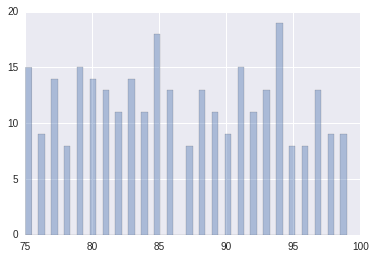

In [7]:
test_seq,test_reads = gen_test_seq(10000,100)
lns = [len(r) for r in test_reads]
sns.distplot(lns,bins=50,kde=False)
print len(test_reads)
print len(test_seq)

### Record runtimes on test datasets

In [8]:
import time
time_easy=[]
time_tricky=[]
sizes_to_test = [200,300,500,800,1000,2000,3000,5000,8000,10000,20000,30000,50000]
for test_size in sizes_to_test:
    test_seq,test_reads = gen_test_seq(test_size,100)
    
    time0 = time.time()
    start,followers = denovo.overlap_all_pairs_easy(test_reads)
    time_easy.append(time.time()-time0)

    time0 = time.time()
    start,followers = denovo.overlap_all_pairs_tricky(test_reads)
    time_tricky.append(time.time()-time0)



## Plot the runtime comparison
Pretty clear that the index takes longer on small datasets, but runs faster on bigger ones

the loglog plot shows the brute force is O(N^2) and the index is O(~N)

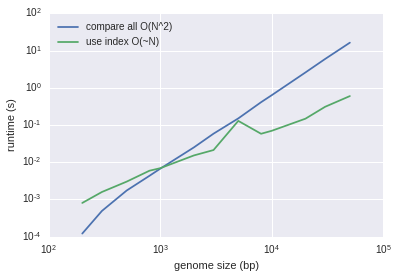

In [9]:
sns.set_style("darkgrid")
plt.loglog(sizes_to_test,time_easy,label='compare all O(N^2)')
plt.loglog(sizes_to_test,time_tricky,label='use index O(~N)')
plt.legend(loc='upper left')
plt.xlabel('genome size (bp)')
plt.ylabel('runtime (s)')